# Understanding Deepfakes with Keras


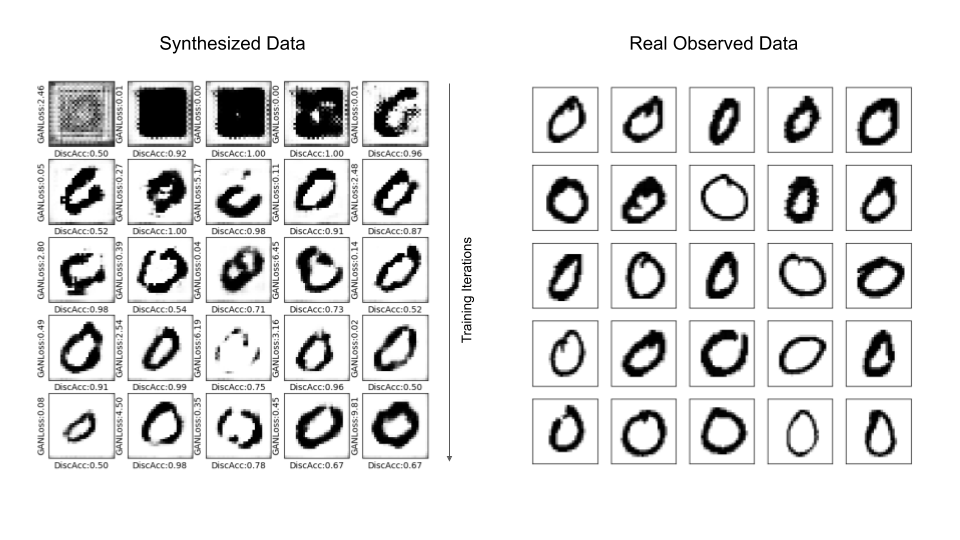

In [ ]:
from IPython.display import Image
Image('DCGAN.png')

# Task 1: Importing Libraries and Helper Functions

In [ ]:
# Installing tfutils
! pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-573wx3an
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-573wx3an
  Created wheel for tfutils: filename=tfutils-0.0.1-cp36-none-any.whl size=6442 sha256=95428ec320490c533270877074af7779370a77aea16edf0048f74b2247980394
  Stored in directory: /tmp/pip-ephem-wheel-cache-er7ku5cg/wheels/fc/ae/41/9164f4ea031c0d70c13ba0d3fa9ab01c6783b36d6324db18ec
Successfully built tfutils


In [ ]:
%matplotlib inline
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


# Task 2: Importing and Plotting the Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot = False)
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)
x = np.concatenate([x_train, x_test], axis = 0)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

<IPython.core.display.Javascript object>

# Task 3: Discriminator

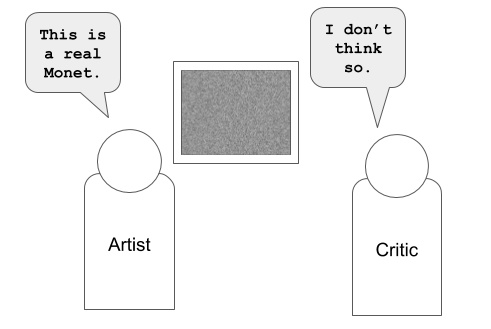

In [ ]:
from IPython.display import Image
Image('artist_critic.png')

In [37]:
discriminator = Sequential([
                            Conv2D(64, 3, strides = 2, input_shape = (28, 28, 1)),
                            LeakyReLU(),
                            BatchNormalization(),

                            Conv2D(128, 5, strides = 2),
                            LeakyReLU(),
                            BatchNormalization(),

                            Conv2D(256, 5, strides = 2),
                            LeakyReLU(),
                            BatchNormalization(),

                            Flatten(),
                            Dense(1, activation= 'sigmoid')

])

opt = tf.keras.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)
discriminator.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 256)        

# Task 4: Generator

In [38]:
generator = Sequential([
                        Dense(256, activation = 'relu', input_shape = (1, )),
                        Reshape((1, 1, 256)),

                        Conv2DTranspose(256, 5, activation = 'relu'),
                        BatchNormalization(),

                        Conv2DTranspose(128, 5, activation = 'relu'),
                        BatchNormalization(),

                        Conv2DTranspose(64, 5,strides= 2, activation = 'relu'),
                        BatchNormalization(),

                        Conv2DTranspose(32, 5, activation = 'relu'),
                        BatchNormalization(),

                        Conv2DTranspose(1, 4, activation = 'sigmoid'),

])
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_24 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 21, 21, 64)       

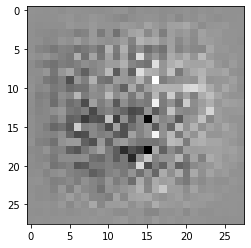

In [39]:
noise = np.random.randn(1, 1)
gen_image = generator.predict(noise)[0]
plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap= 'binary')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [40]:
input_layer = tf.keras.layers.Input(shape = (1, ))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [41]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/ batch_size)

print("Steps per epoch:", steps_per_epoch)

Steps per epoch: 107


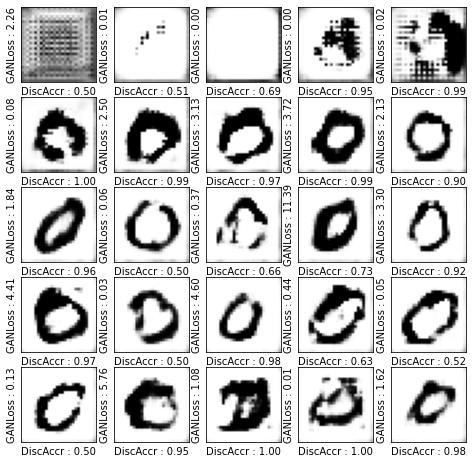

In [42]:
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
  dp.start_of_epoch(e)

  for step in range(0, steps_per_epoch):
    true_examples = x[int(batch_size/2) * step : int(batch_size/2) * (step + 1)]
    true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1) )

    noise = np.random.randn(int(batch_size/2), 1)
    gen_examples = generator.predict(noise)

    x_batch = np.concatenate([gen_examples, true_examples], axis = 0)
    # 0 for false examples, 1 for true examples
    y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2)) 

    indices = np.random.choice(range(batch_size), batch_size, replace = False)

    x_batch = x_batch[indices]
    y_batch = y_batch[indices]

    discriminator.trainable = True
    discriminator.train_on_batch(x_batch, y_batch)
    discriminator.trainable = False
    
    # If given noise, the generator should be able to create some output
    # which will be predicted as true_examples by the discriminator
    loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
    _, acc = discriminator.evaluate(x_batch, y_batch, verbose= False)

  noise = np.random.randn(1, 1)
  gen_image = generator.predict(noise)[0]
  gen_image = np.reshape(gen_image, (28, 28))
  dp.end_of_epoch(gen_image, 'binary', 'DiscAccr : {:.2f}'.format(acc), 'GANLoss : {:.2f}'.format(loss))